In [1]:
import torch
import os
import matplotlib.pyplot as plt

In [24]:
from  torch_geometric.nn import GCNConv
from torch.nn import ModuleList

In [25]:
l = GCNConv(16, 32, improved=False, cached=True, add_self_loops=True)
for param in l.parameters():
    param.requires_grad = False
ml = ModuleList()
ml.append(l)

ModuleList(
  (0): GCNConv(16, 32)
)

In [26]:
import torch
x = torch.randn(100, 16)
edge_index = torch.randint(0, 100, (2, 1000))
edge_weight = torch.randn(1000)
edge_weight.requires_grad = True
print(edge_index)

tensor([[16, 81, 17,  ..., 58, 92, 60],
        [57, 21, 39,  ..., 42, 33, 80]])


In [29]:
ml[0]

GCNConv(16, 32)

In [28]:
o = ml[0](x, edge_index,edge_weight)
o.requires_grad

True

In [2]:
# load files in folder
def load_files(folder):
    probs0 = []
    probs1 = []
    predictions1 = []
    predictions0 = []
    for file in os.listdir(folder):
        if file.endswith(".pt"):
            s = file.split("_")
            f = os.path.join(folder,file)
            p = probs0 if s[2] == "0" else probs1
            predictions = predictions0 if s[2] == "0" else predictions1
            pred = torch.load(f)
            probs = pred.get_probabilities(propagated=True)
            p.append(probs)
            predictions.append(pred)
            
    return probs0, probs1, predictions0, predictions1

In [3]:
probs0, probs1, p0,p1 = load_files("../tta")

/tmp/ipykernel_911442/2546805646.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred = torch.load(f)


In [4]:
ix = 11
first = probs0[ix][0]
last = torch.softmax(p1[ix].get_logits(propagated=True)/101, dim=-1)[0]
print(first.std())
print(last.std())

tensor(0.1698, device='cuda:0')
tensor(0.2378, device='cuda:0')


In [78]:
cnt = 0
for k in range(len(p0)):
    op = torch.softmax(p0[k].get_logits(propagated=True)[0],dim=-1)
    sp = torch.softmax((p0[k].get_logits(propagated=True)*100)[0],dim=-1)
    
    fc = op.max(-1)[0].argmin()
    lc = sp.max(-1)[0].argmin()
    print(fc,lc)
    break
    # if torch.softmax(p0[k].get_logits(propagated=True)[0],dim=-1).max(-1)[0].argmin() != torch.softmax((p0[k].get_logits(propagated=True)*100)[0],dim=-1).max(-1)[0].argmin():
    #     cnt += 1 
print(cnt)

tensor(2610, device='cuda:0') tensor(1102, device='cuda:0')
0


In [83]:
print(op[fc].max(),op[lc].max())
print(sp[fc].max(),sp[lc].max())

tensor(0.1993, device='cuda:0') tensor(0.3311, device='cuda:0')
tensor(1., device='cuda:0') tensor(0.5240, device='cuda:0')


In [86]:
op[fc],sp[fc]

(tensor([0.1993, 0.1333, 0.1673, 0.1587, 0.1497, 0.0713, 0.1205],
        device='cuda:0'),
 tensor([1.0000e+00, 3.3941e-18, 2.5883e-08, 1.2672e-10, 3.6573e-13, 2.8026e-45,
         1.4123e-22], device='cuda:0'))

In [85]:
op[lc],sp[lc]

(tensor([0.3307, 0.1640, 0.0230, 0.0301, 0.1071, 0.3311, 0.0141],
        device='cuda:0'),
 tensor([4.7599e-01, 1.6219e-31, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2401e-01,
         0.0000e+00], device='cuda:0'))

In [90]:
l = (p1[ix].get_logits(propagated=True)/101)[0].cpu().detach()
f = p0[ix].get_logits(propagated=True)[0].cpu().detach()

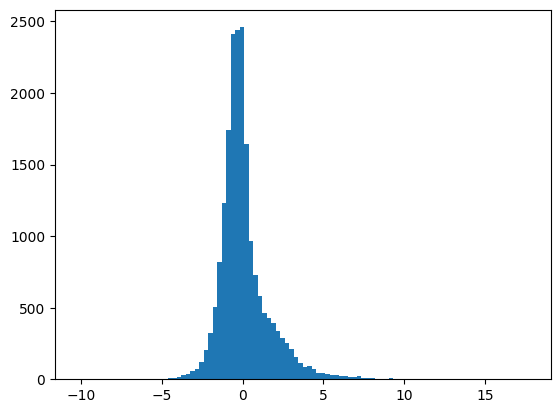

In [100]:
plt.hist((l-f).flatten(), bins=100)
plt.show()

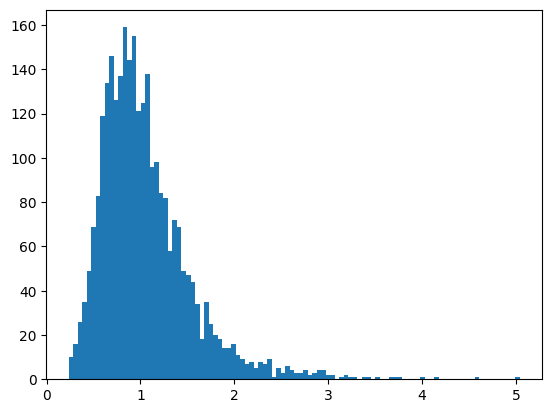

In [101]:
plt.hist((l-f).abs().mean(dim=-1).flatten(),bins=100)
plt.show()

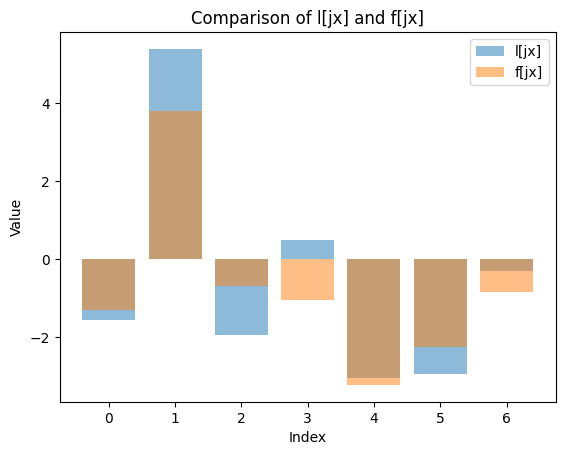

In [96]:
jx = 1
# plt.bar(range(7), l[jx] - f[jx])
plt.bar(range(7), l[jx], alpha=0.5, label='l[jx]')
plt.bar(range(7), f[jx], alpha=0.5, label='f[jx]')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of l[jx] and f[jx]')
plt.show()


In [60]:
f[0]

array([ 1.7785448 , -0.0663761 , -0.8213744 , -0.02669439, -3.4290485 ,
       -1.0846438 ,  0.25266722], dtype=float32)

In [37]:
# TTA MAKES PREDICTIONS MORE CONFIDENT
first.max(dim=1)[0].mean(), last.max(dim=1)[0].mean()

(tensor(0.4773, device='cuda:0'), tensor(0.6632, device='cuda:0'))

In [38]:
diff = first-last
diff.std(), diff.max(), diff.min(), diff.median()

(tensor(0.1679, device='cuda:0'),
 tensor(0.6931, device='cuda:0'),
 tensor(-0.9990, device='cuda:0'),
 tensor(0.0272, device='cuda:0'))

In [39]:
max_values = last.max(1)[0]
num_bins = 100
bin_counts = torch.histc(max_values, bins=num_bins).cpu().numpy()


In [40]:
last.shape

torch.Size([2810, 7])

In [41]:
prediction_change = (first.argmax(dim=1) != last.argmax(dim=1))
prediction_not_change = (first.argmax(dim=1) == last.argmax(dim=1))
print(prediction_change.sum()/first.shape[0], prediction_not_change.sum()/first.shape[0])
print(first[prediction_change].max(dim=1)[0].mean(), first[prediction_change].max(dim=1)[0].std())
print(last[prediction_change].max(dim=1)[0].mean(),last[prediction_change].max(dim=1)[0].std())

tensor(0.3509, device='cuda:0') tensor(0.6491, device='cuda:0')
tensor(0.3336, device='cuda:0') tensor(0.1000, device='cuda:0')
tensor(0.5893, device='cuda:0') tensor(0.2365, device='cuda:0')


In [42]:
# PREDICTIONS CHANGES FOR LESS CONFIDENT PREDICTIONS
print(first[prediction_not_change].max(dim=1)[0].mean(), first[prediction_not_change].max(dim=1)[0].std())
print(last[prediction_not_change].max(dim=1)[0].mean(),last[prediction_not_change].max(dim=1)[0].std())

tensor(0.5550, device='cuda:0') tensor(0.2083, device='cuda:0')
tensor(0.7032, device='cuda:0') tensor(0.2195, device='cuda:0')


In [43]:
print(torch.bincount(first[prediction_change].argmax(dim=1)))
print(torch.bincount(last[prediction_change].argmax(dim=1)))

tensor([371, 395,  71,   6,   0,  12, 131], device='cuda:0')
tensor([ 44,  18,  28, 333, 475,  33,  55], device='cuda:0')


[[  0   9  17  68 235  11  31]
 [ 34   0   3 225  92  22  19]
 [  0   1   0   0  65   0   5]
 [  1   1   2   0   2   0   0]
 [  0   0   0   0   0   0   0]
 [  6   3   0   1   2   0   0]
 [  3   4   6  39  79   0   0]]


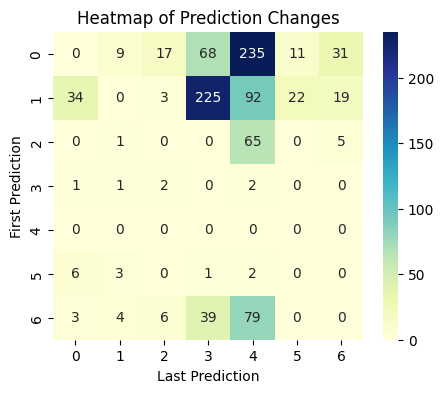

In [44]:
from collections import Counter
import numpy as np
import seaborn as sns

# first[prediction_change].argmax(dim=1)
first_pairs = Counter(zip(first[prediction_change].argmax(dim=1).cpu().numpy(), last[prediction_change].argmax(dim=1).cpu().numpy()))
# print(first_pairs)
# Create a matrix from the Counter
matrix_size = (max(first_pairs.keys(), key=lambda x: x[0])[0] + 1, max(first_pairs.keys(), key=lambda x: x[1])[1] + 1)
matrix = np.zeros(matrix_size, dtype=int)

for (i, j), count in first_pairs.items():
    matrix[i, j] = count

print(matrix)
plt.figure(figsize=(5,4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Last Prediction')
plt.ylabel('First Prediction')
plt.title('Heatmap of Prediction Changes')
plt.show()


In [187]:
appr = torch.load("../A_ppr.pt")
appr[1:,1:].max(dim=1)

/tmp/ipykernel_798644/2229006065.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  appr = torch.load("../A_ppr.pt")


torch.return_types.max(
values=tensor([0.1503, 0.1503, 0.1503,  ..., 0.1503, 0.1503, 0.1503]),
indices=tensor([   0,    1,    2,  ..., 2806, 2807, 2808]))

In [227]:
# Define the size of the matrix
rows, cols = 5, 5  # Example size, you can change it as needed

# Generate a random binary matrix
binary_matrix = torch.randint(0, 2, (rows, cols)).float()
binary_matrix

tensor([[0., 1., 0., 1., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 1.],
        [0., 1., 1., 0., 0.]])

In [251]:
degrees = binary_matrix.sum(dim=1)
D_inv = torch.diag(1.0 / degrees)
T = torch.mm(D_inv, binary_matrix)
n = binary_matrix.size(0)
I = torch.eye(n, device=binary_matrix.device)
alpha = 0.1
T

tensor([[0.0000, 0.3333, 0.0000, 0.3333, 0.3333],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
        [0.0000, 0.3333, 0.3333, 0.0000, 0.3333],
        [0.0000, 0.5000, 0.5000, 0.0000, 0.0000]])

In [254]:
t=100
diffusion_matrix = torch.exp(-(I-T)*t)
diffusion_matrix


tensor([[3.7835e-44, 2.9956e+14, 1.0000e+00, 2.9956e+14, 2.9956e+14],
        [       inf, 3.7835e-44, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [2.9956e+14, 1.0000e+00, 3.7835e-44, 2.9956e+14, 2.9956e+14],
        [1.0000e+00, 2.9956e+14, 2.9956e+14, 3.7835e-44, 2.9956e+14],
        [1.0000e+00, 5.1847e+21, 5.1847e+21, 1.0000e+00, 3.7835e-44]])